# Notions of Feedback Control

## Preliminaries

The next lines setup some things and import the various libraries required to run this notebook.

Don't forget to initialize the server with:

    sudo pyctrl_start_server -m pyctrl.rc.drive


## Preliminaries

The next lines setup some things and import the various libraries required to run this notebook.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import math
import time

from pyctrl.block import ShortCircuit, Wrap
from pyctrl.block.system import Differentiator, Gain, Feedback, System, Sum, Subtract
from pyctrl.block import Interp, Logger, Constant
from pyctrl.system.tf import PID

from pyctrl.client import Controller
HOST, PORT = "192.168.8.1", 9999
mip = Controller(host = HOST, port = PORT)

mip.reset()
print(mip.info('all'))

<class 'pyctrl.rc.drive.Controller'> with:
  0 timer(s), 10 signal(s),
  4 source(s), 0 filter(s), and 2 sink(s)
> timers
> signals
  1. clock
  2. duty
  3. encoder1
  4. encoder2
  5. is_running
  6. pitch
  7. pwm1
  8. pwm2
  9. roll
  10. yaw
> sources
  1. clock[MPU9250, enabled] >> clock
  2. orientation[TaitBryanAngles, enabled] >> pitch, roll, yaw
  3. encoder1[Encoder, enabled] >> encoder1
  4. encoder2[Encoder, enabled] >> encoder2
> filters
> sinks
  1. pwm1 >> motor1[Motor, disabled]
  2. pwm2 >> motor2[Motor, disabled]



## Model for the motor

It is helpful to think of the motors in the MIP as an entity that takes an **input signal**, for example a `pwm` signal, and produces an **output signal**, in this case an *angular velocity*. We represent such **input-output** relationship using a **block-diagram**:

<img src="http://guitar.ucsd.edu/cosmos7/images/blk1.svg" width="300">

You have already performed experiments to characterize the behavior of the motors in the MIP. Recall that the parameters `a` and `b` you obtained were similar to the ones below:

In [2]:
a = 0.084
b = -0.681

Mathematically the model could be represented by the function

$$
v(x) = \begin{cases}
a x + b, & x \geq -b/a \\
0, & b/a < x < -b/a \\
a x - b, & x \leq b/a
\end{cases}
$$

where $x$ represents a `pwm` signal and $x$ the motor velocity.

A plot of the response looked like:

<IPython.core.display.Javascript object>


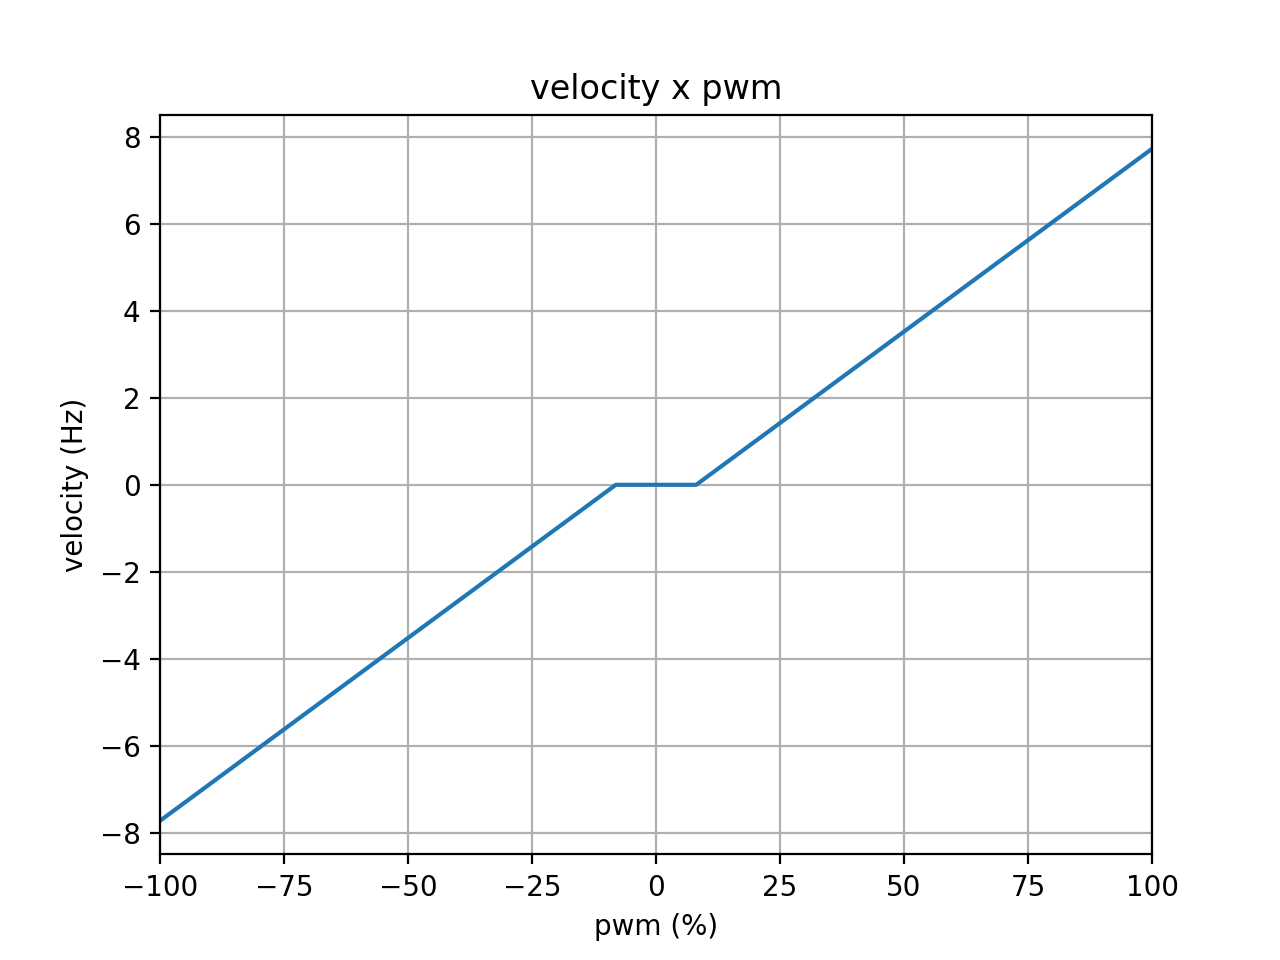

In [3]:
# build interpolated input signal
vs = [-100*a-b, 0, 0, 100*a+b]
pwms = [-100, b/a, -b/a, 100]

plt.figure()
plt.plot(pwms,vs)
plt.xlabel('pwm (%)')
plt.ylabel('velocity (Hz)')
plt.title('velocity x pwm')
plt.xlim((-100,100))
plt.grid()

A simpler model to work with is the linear model:

$$
v(x) = g x
$$

### Questions

1. Explain why a value of $g = a + b/100$ constitute a suitable linear model for the MIP motors.
2. In which regions of operation do you expect the linear model to be accurate? 
3. In which regions of operation do you expect the linear model to be inaccurate? 

### Tasks

1. Plot the response of the linear model and the piecewise-linear model discussed before in a single graph.

In [4]:
g = a+b/100

<IPython.core.display.Javascript object>


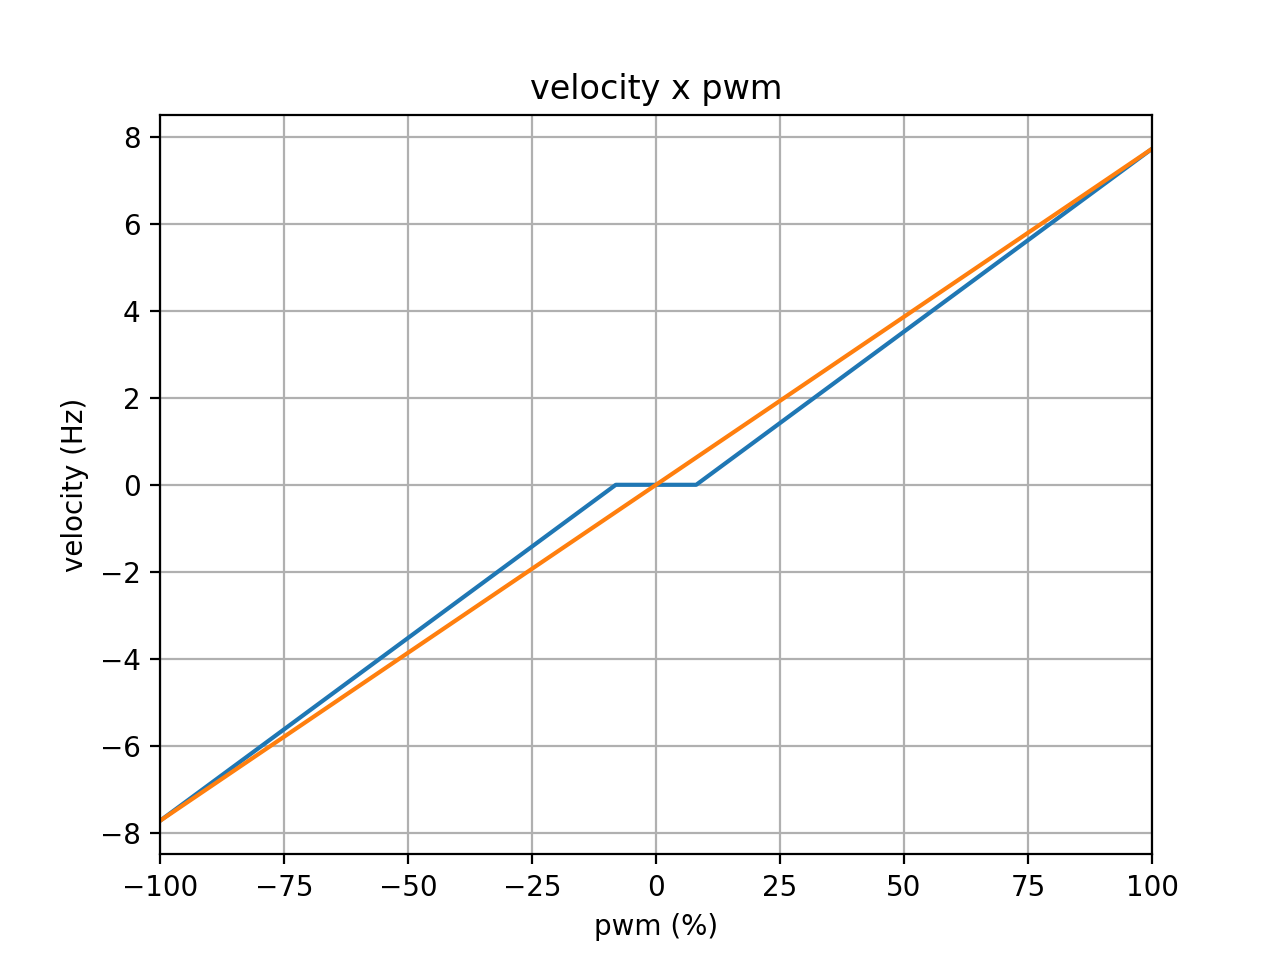

In [5]:
# SOLUTION
vs = [-100*a-b, 0, 0, 100*a+b]
pwms = [-100, b/a, -b/a, 100]

lvs = [-100*g, 100*g]
lpwms = [-100, 100]

plt.figure()
plt.plot(pwms, vs, lpwms, lvs)
plt.xlabel('pwm (%)')
plt.ylabel('velocity (Hz)')
plt.title('velocity x pwm')
plt.xlim((-100,100))
plt.grid()

## Open-loop Velocity Control

In open-loop control, the control input, in this case the voltage controlled by the `pwm` signal is produced by an algorithm, the **controller**, in response to a **reference signal**, in this case a velocity, as shown in the following block-diagram:

<img src="http://guitar.ucsd.edu/cosmos7/images/blk2.svg" width="500">

### Tasks
1. Use the linear model, $v(x) = g x$, where $x$ is the `pwm` signal input to calculate the value of $x$ required to make the motor rotate at an angular velocity $v = 2$Hz.
2. Repeat for $v = 1$Hz.
3. Generalize the calculation to work for any desired velocity: that's an **open-loop controller**
4. Implement the resulting controller, set the velocity reference for the motor1 to be 1Hz and the velocity reference for the motor2 to be 2Hz and run your controller for 5 seconds.
5. Import the data and plot time vs velocity and time vs reference
6. Discard the first second of data and use `np.mean` and `np.std` to calculate the average and standard deviation of the measured velocities. Calculate also the average absolute error between the reference velocities and the actual velocity.

In [ ]:
K = 1/g

In [ ]:
# Run time
T = 5

# Add reference signal
mip.add_signals('ref_velocity1',
                'ref_velocity2')

# add differentiators
mip.add_signals('velocity1','velocity2')
mip.add_filter('velocity1', Differentiator(), ['clock', 'encoder1'],['velocity1'])
mip.add_filter('velocity2', Differentiator(), ['clock', 'encoder2'],['velocity2'])

# Open-loop controllers
mip.add_filter('Controller1',
                Gain(gain = K),
                ['ref_velocity1'],
                ['pwm1'])

mip.add_filter('Controller2',
                Gain(gain = K),
                ['ref_velocity2'],
                ['pwm2'])

# add logger
mip.add_sink('logger', Logger(auto_reset = True),
             ['clock', 
              'encoder1', 'encoder2', 
              'velocity1','velocity2',
              'pwm1','pwm2'])

# add a timer to stop the controller
mip.add_timer('stop',
               Constant(value = 0),
               None, ['is_running'],
               period = T, repeat = False)

print(mip.info('all'))

Set the reference velocities, run the MIP and collect the output data:

In [ ]:
ref_velocity1 = 1
ref_velocity2 = 2

mip.set_signal('ref_velocity1', ref_velocity1)
mip.set_signal('ref_velocity2', ref_velocity2)
with mip:
    mip.join()
log = mip.get_sink('logger', 'log')

Calculate average velocity and standard deviation after 1 second:

In [ ]:
clock = log['clock']
mean_velocity1 = log['velocity1'][clock > clock[0] + 1].mean()
std_velocity1 = log['velocity1'][clock > clock[0] + 1].std()
error_velocity1 = np.fabs(log['velocity1'][clock > clock[0] + 1]-ref_velocity1).mean()
print('velocity1: mean = {:5.3f}, std = {:5.3f}%, error = {:5.3f}%'.format(mean_velocity1,100*std_velocity1/mean_velocity1, 100*error_velocity1/ref_velocity1))

mean_velocity2 = log['velocity2'][clock > clock[0] + 1].mean()
std_velocity2 = log['velocity2'][clock > clock[0] + 1].std()
error_velocity2 = np.fabs(log['velocity2'][clock > clock[0] + 1]-ref_velocity2).mean()
print('velocity2: mean = {:5.3f}, std = {:5.3f}%, error = {:5.3f}%'.format(mean_velocity2,100*std_velocity2/mean_velocity2, 100*error_velocity2/ref_velocity2))

Plot *velocities versus time*:

In [ ]:
plt.figure()
plt.plot(log['clock'], log['velocity1'], 'b',
         [clock[0],clock[-1]], [ref_velocity1,ref_velocity1], 'b--',
         [clock[0],clock[-1]], [mean_velocity1,mean_velocity1], 'b',
         log['clock'], log['velocity2'], 'r',
         [clock[0],clock[-1]], [ref_velocity2,ref_velocity2], 'r--',
         [clock[0],clock[-1]], [mean_velocity2,mean_velocity2], 'r' )
plt.xlabel('time (s)')
plt.ylabel('velocity (Hz)')
plt.title('velocity x time')
plt.grid()

Plot *pwm versus time*:

In [ ]:
plt.figure()
plt.plot(clock, log['pwm1'],
         clock, log['pwm2'])
plt.ylabel('pwm (%)')
plt.xlabel('time (s)')
plt.title('pwm x time')
plt.grid()

## Closed-loop Velocity Control

In closed-loop control, the control input, in this case the voltage controlled by the `pwm` signal, is also produced by an algorithm, the **controller**. However, in addition to the **reference signal**, in this case a velocity, the controller also responds to a **measurement**, in this case the velocity, which is **fedback** into the signal producing the measurement as shown in the following block-diagram:

<img src="http://guitar.ucsd.edu/cosmos7/images/blk3.svg" width="600">

With the purpose of analyzing the resulting closed-loop system assume that the motor and the controller are both well represented by the linear models:

$$
\begin{aligned}
v(x) &= g \, x, &
x(e) &= k \, e
\end{aligned}
$$
where $e$ represents the **error** signal in the above diagram.

### Questions

1. Show that
$$
\begin{aligned}
  v(r) &= H r, &
  H &= \frac{k \, g}{1 + k \, g}
\end{aligned}
$$
where $r$ represents the **reference** signal.
2. What value of gain $k$ is required if $H$ is to be equal to one? What would happen in that case?

### Tasks
1. Use the values of $g = -b/a$ and calculate the values of $H$ for $k = 25$.
2. Repeat for $k = 50$, $100$, and $200$. 
3. Implement the resulting controller for the various values of $k$ above, set the velocity reference for the motor1 to be 1Hz and the velocity reference for the motor2 to be 2Hz and run your controller for 5 seconds.
4. Import the data and plot time vs velocity and time vs reference
5. Discard the first second of data and use `np.mean` and `np.std` to calculate the average and standard deviation of the measured velocities. Calculate also the average absolute error between the reference velocities and the actual velocity.
6. What happens as $k$ is gets large?

In [6]:
Ks = np.array([25,50,100,200])
Hs = g*Ks/(1 + g*Ks)

print('Ks = {}'.format(Ks))
print('Hs = {}'.format(Hs))

Ks = [ 25  50 100 200]
Hs = [ 0.65867395  0.79421751  0.88530795  0.93916535]


In [11]:
i = 0

K = float(Ks[i])
H = float(Hs[i])
print('K = Ks[{}] = {:5.3f}'.format(i,K))
print('H = Hs[{}] = {:5.3f}'.format(i,H))

K = Ks[0] = 25.000
H = Hs[0] = 0.659


In [12]:
# Run time
T = 5

# Add reference signal
mip.add_signals('ref_velocity1',
                'ref_velocity2')

# add differentiators
mip.add_signals('velocity1','velocity2')
mip.add_filter('velocity1', Differentiator(), ['clock', 'encoder1'],['velocity1'])
mip.add_filter('velocity2', Differentiator(), ['clock', 'encoder2'],['velocity2'])

# Open-loop controllers
mip.add_filter('Controller1',
                Feedback(block = Gain(gain = K)),
                ['velocity1','ref_velocity1'],
                ['pwm1'])

mip.add_filter('Controller2',
                Feedback(block = Gain(gain = K)),
                ['velocity2','ref_velocity2'],
                ['pwm2'])

# add logger
mip.add_sink('logger', Logger(auto_reset = True),
             ['clock', 
              'encoder1', 'encoder2', 
              'velocity1','velocity2',
              'pwm1','pwm2'])

# add a timer to stop the controller
mip.add_timer('stop',
               Constant(value = 0),
               None, ['is_running'],
               period = T, repeat = False)

print(mip.info('all'))

<class 'pyctrl.rc.drive.Controller'> with:
  1 timer(s), 14 signal(s),
  4 source(s), 4 filter(s), and 3 sink(s)
> timers
  1. stop[Constant, period = 5.0, enabled] >> is_running
> signals
  1. clock
  2. duty
  3. encoder1
  4. encoder2
  5. is_running
  6. pitch
  7. pwm1
  8. pwm2
  9. ref_velocity1
  10. ref_velocity2
  11. roll
  12. velocity1
  13. velocity2
  14. yaw
> sources
  1. clock[MPU9250, enabled] >> clock
  2. orientation[TaitBryanAngles, enabled] >> pitch, roll, yaw
  3. encoder1[Encoder, enabled] >> encoder1
  4. encoder2[Encoder, enabled] >> encoder2
> filters
  1. clock, encoder1 >> velocity1[Differentiator, enabled] >> velocity1
  2. clock, encoder2 >> velocity2[Differentiator, enabled] >> velocity2
  3. velocity1, ref_velocity1 >> Controller1[Feedback, enabled] >> pwm1
  4. velocity2, ref_velocity2 >> Controller2[Feedback, enabled] >> pwm2
> sinks
  1. pwm1 >> motor1[Motor, disabled]
  2. pwm2 >> motor2[Motor, disabled]
  3. clock, encoder1, encoder2, velocity1, v

Set the reference velocities, run the MIP and collect the output data:

In [13]:
ref_velocity1 = 1
ref_velocity2 = 2

mip.set_signal('ref_velocity1', ref_velocity1)
mip.set_signal('ref_velocity2', ref_velocity2)
with mip:
    mip.join()
log = mip.get_sink('logger', 'log')

Calculate average velocity and standard deviation after 1 second:

In [14]:
clock = log['clock']
mean_velocity1 = log['velocity1'][clock > clock[0] + 1].mean()
std_velocity1 = log['velocity1'][clock > clock[0] + 1].std()
error_velocity1 = np.fabs(log['velocity1'][clock > clock[0] + 1]-ref_velocity1).mean()
print('velocity1: mean = {:5.3f}, std = {:5.3f}%, error = {:5.3f}%'.format(mean_velocity1,100*std_velocity1/mean_velocity1, 100*error_velocity1/ref_velocity1))

mean_velocity2 = log['velocity2'][clock > clock[0] + 1].mean()
std_velocity2 = log['velocity2'][clock > clock[0] + 1].std()
error_velocity2 = np.fabs(log['velocity2'][clock > clock[0] + 1]-ref_velocity2).mean()
print('velocity2: mean = {:5.3f}, std = {:5.3f}%, error = {:5.3f}%'.format(mean_velocity2,100*std_velocity2/mean_velocity2, 100*error_velocity2/ref_velocity2))

velocity1: mean = 0.616, std = 6.261%, error = 38.420%
velocity2: mean = 1.047, std = 4.995%, error = 47.670%


Plot *velocities versus time*:

<IPython.core.display.Javascript object>


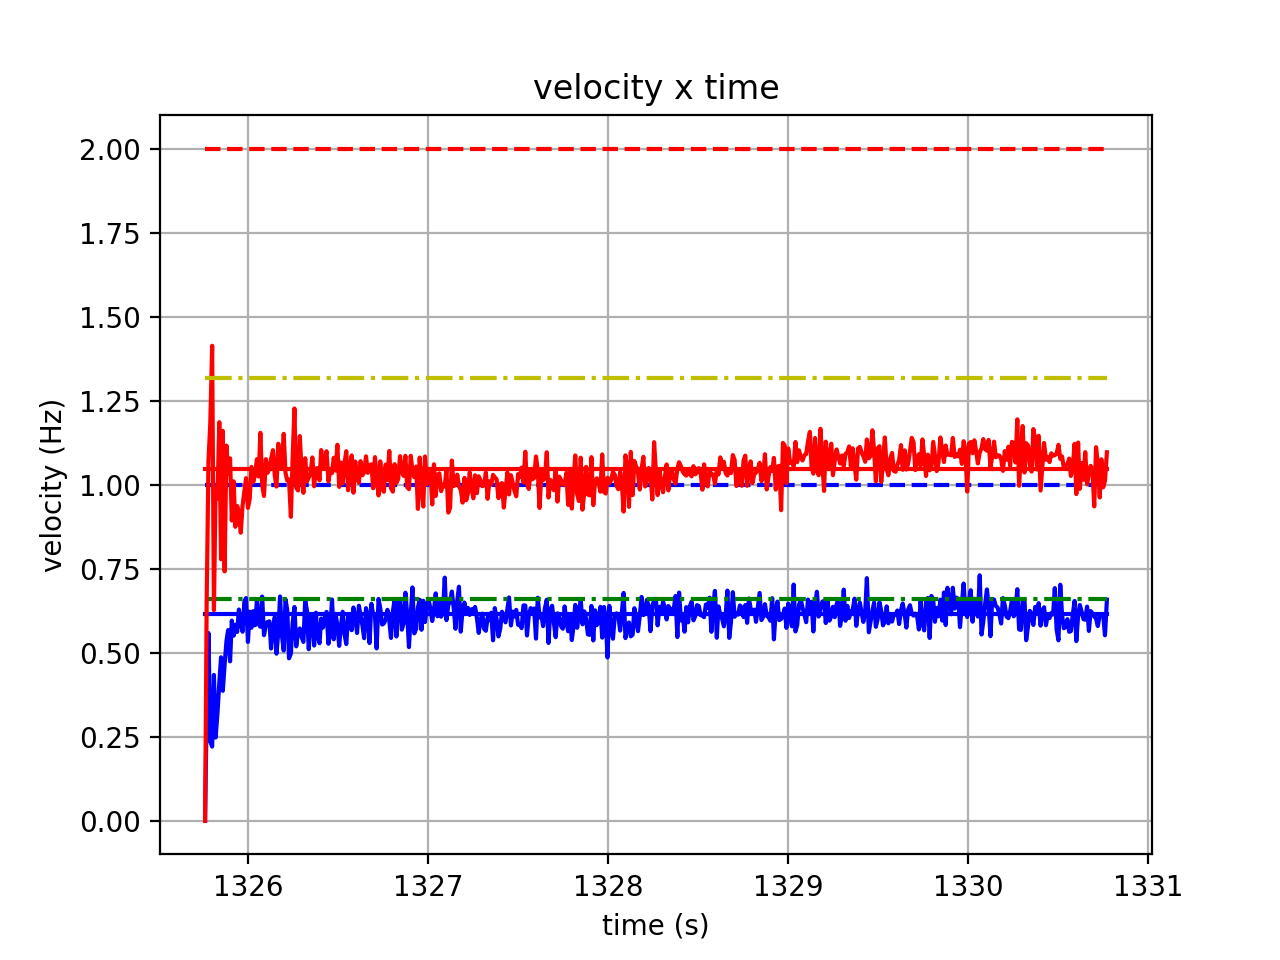

In [15]:
plt.figure()
plt.plot(log['clock'], log['velocity1'], 'b',
         [clock[0],clock[-1]], [ref_velocity1,ref_velocity1], 'b--',
         [clock[0],clock[-1]], [H*ref_velocity1,H*ref_velocity1], 'g-.',
         [clock[0],clock[-1]], [mean_velocity1,mean_velocity1], 'b',
         log['clock'], log['velocity2'], 'r',
         [clock[0],clock[-1]], [ref_velocity2,ref_velocity2], 'r--',
         [clock[0],clock[-1]], [H*ref_velocity2,H*ref_velocity2], 'y-.',
         [clock[0],clock[-1]], [mean_velocity2,mean_velocity2], 'r' )
plt.xlabel('time (s)')
plt.ylabel('velocity (Hz)')
plt.title('velocity x time')
plt.grid()

Plot *pwm versus time*:

<IPython.core.display.Javascript object>


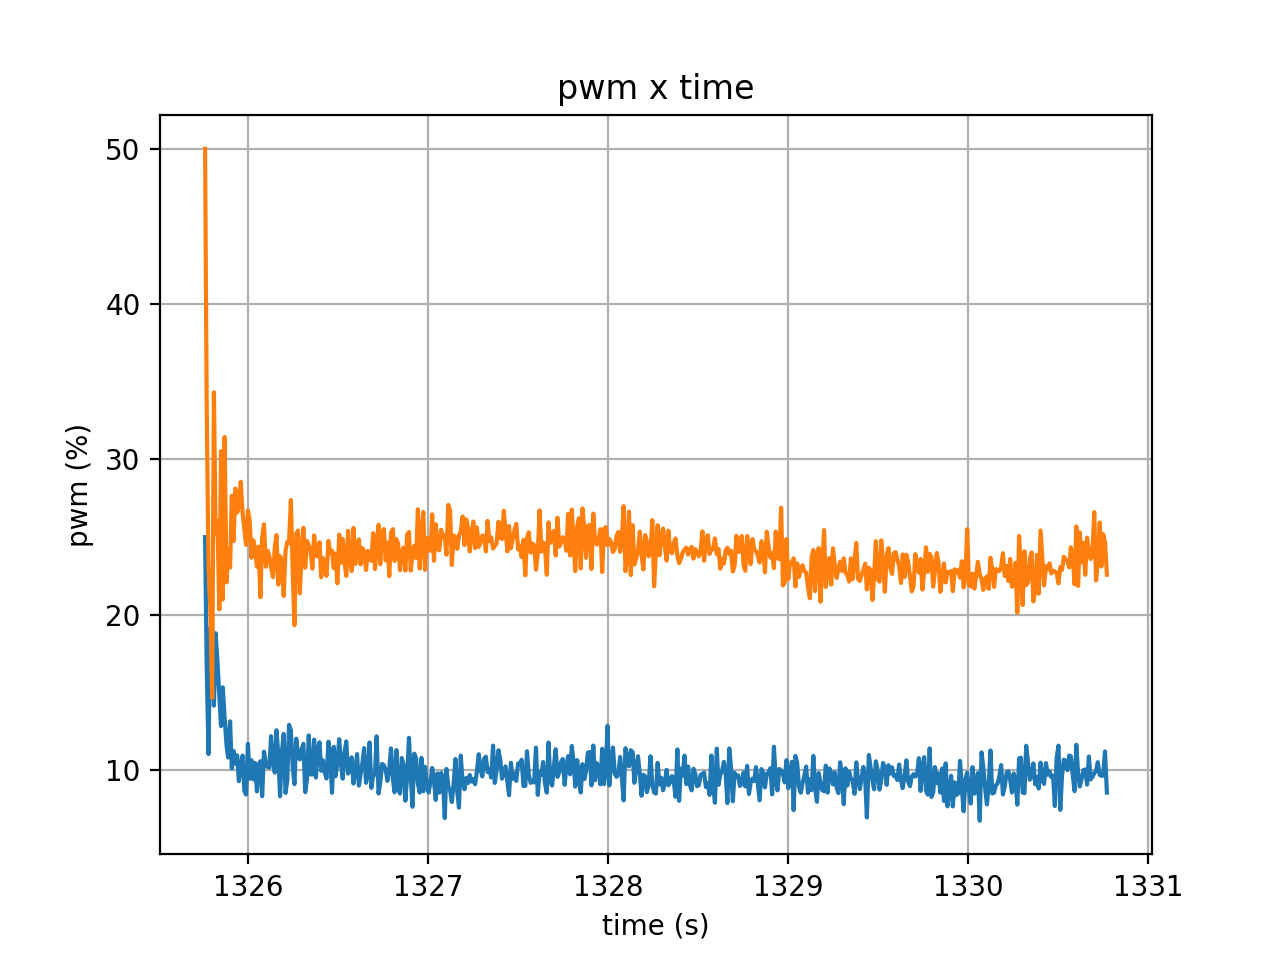

In [16]:
plt.figure()
plt.plot(clock, log['pwm1'],
         clock, log['pwm2'])
plt.ylabel('pwm (%)')
plt.xlabel('time (s)')
plt.title('pwm x time')
plt.grid()

## Closed-loop Position Control

Feedback can be used to control any quantity which can be measured. The underlying algorithm is often based on the exact same diagram you studied before. For example, if one would like to control the position of the MIP rather than its velocity, then one could use position feedback as in the following diagram:

<img src="http://guitar.ucsd.edu/cosmos7/images/blk4.svg" width="600">

### Questions

1. What does the symbol $\int$ mean?

### Tasks
1. Implement a feedback controller for position control using $k = 25$, set the position reference for the motor1 to be 1 cycle and the position reference for the motor2 to be 2 cycles and run your controller for 5 seconds.
2. Import the data and plot time vs position and time vs reference.
3. What happens as $k$ is gets large?


In [20]:
i = 0

K = float(Ks[i])
print('K = Ks[{}] = {:5.3f}'.format(i,K))

K = Ks[0] = 25.000


Add the reference input and the closed-loop controller to the device:

In [21]:
# Add position reference signal
mip.add_signals('ref_encoder1',
                'ref_encoder2')

# add differentiators
mip.add_signals('velocity1','velocity2')
mip.add_filter('velocity1', Differentiator(), ['clock', 'encoder1'],['velocity1'])
mip.add_filter('velocity2', Differentiator(), ['clock', 'encoder2'],['velocity2'])

# Open-loop controllers
mip.add_filter('Controller1',
                Feedback(block = Gain(gain = K)),
                ['encoder1','ref_encoder1'],
                ['pwm1'])

mip.add_filter('Controller2',
                Feedback(block = Gain(gain = K)),
                ['encoder2','ref_encoder2'],
                ['pwm2'])

# add logger
mip.add_sink('logger', Logger(auto_reset = True),
             ['clock', 
              'encoder1', 'encoder2', 
              'velocity1','velocity2',
              'ref_encoder1','ref_encoder2',
              'pwm1','pwm2'])

# add a timer to stop the controller
mip.add_timer('stop',
               Constant(value = 0),
               None, ['is_running'],
               period = 5, repeat = False)

print(mip.info('all'))

<class 'pyctrl.rc.drive.Controller'> with:
  1 timer(s), 16 signal(s),
  4 source(s), 4 filter(s), and 3 sink(s)
> timers
  1. stop[Constant, period = 5.0, enabled] >> is_running
> signals
  1. clock
  2. duty
  3. encoder1
  4. encoder2
  5. is_running
  6. pitch
  7. pwm1
  8. pwm2
  9. ref_encoder1
  10. ref_encoder2
  11. ref_velocity1
  12. ref_velocity2
  13. roll
  14. velocity1
  15. velocity2
  16. yaw
> sources
  1. clock[MPU9250, enabled] >> clock
  2. orientation[TaitBryanAngles, enabled] >> pitch, roll, yaw
  3. encoder1[Encoder, enabled] >> encoder1
  4. encoder2[Encoder, enabled] >> encoder2
> filters
  1. clock, encoder1 >> velocity1[Differentiator, enabled] >> velocity1
  2. clock, encoder2 >> velocity2[Differentiator, enabled] >> velocity2
  3. encoder1, ref_encoder1 >> Controller1[Feedback, enabled] >> pwm1
  4. encoder2, ref_encoder2 >> Controller2[Feedback, enabled] >> pwm2
> sinks
  1. pwm1 >> motor1[Motor, disabled]
  2. pwm2 >> motor2[Motor, disabled]
  3. clock

In [22]:
mip.set_signal('ref_encoder1', 1)
mip.set_signal('ref_encoder2', 2)

mip.set_source('encoder1', reset=True)
mip.set_source('encoder2', reset=True)
mip.set_source('clock', reset=True)
with mip:
    mip.join()
log = mip.get_sink('logger', 'log')

<IPython.core.display.Javascript object>


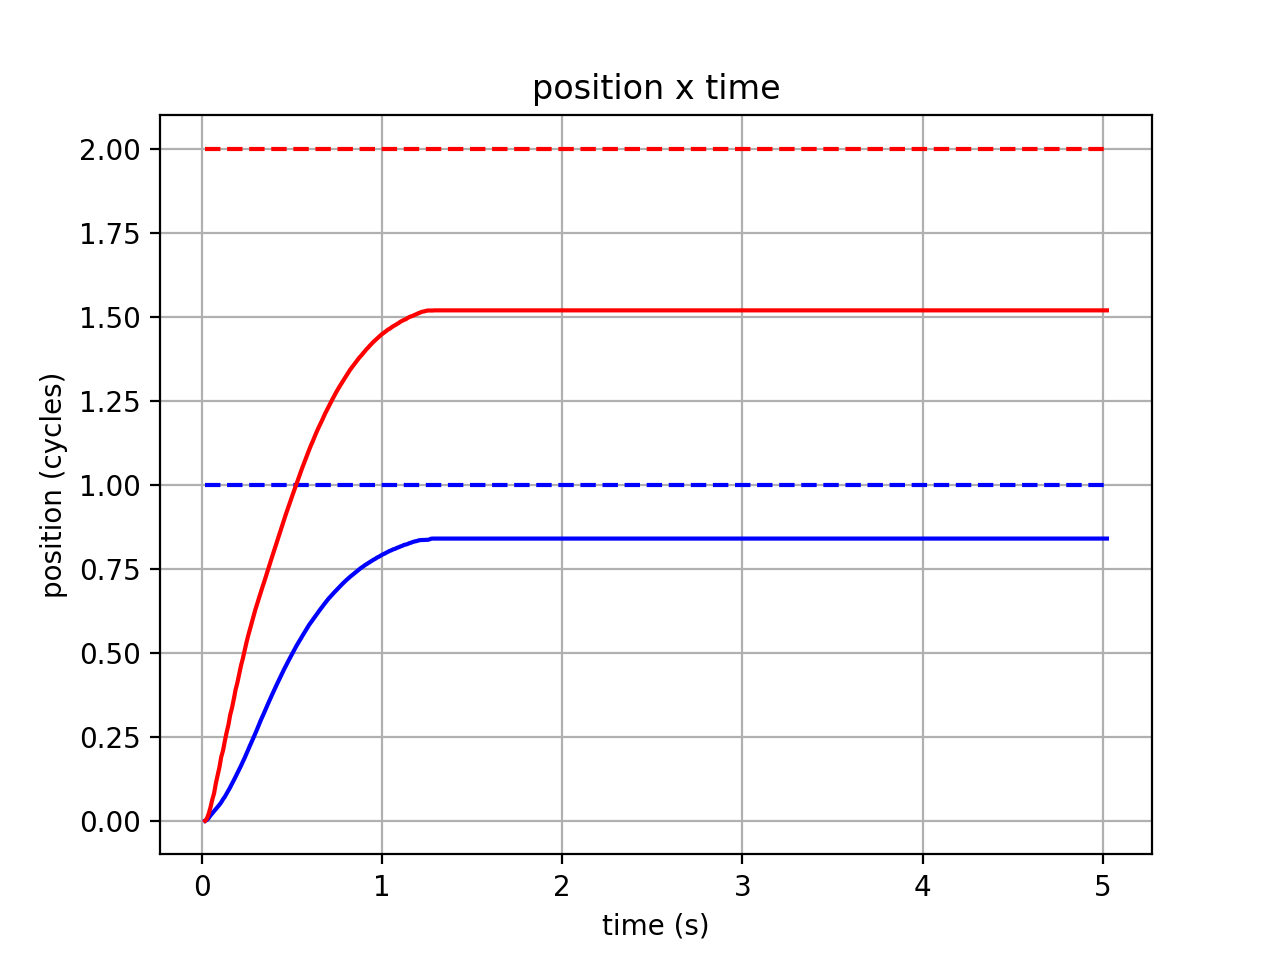

In [23]:
clock = log['clock']

plt.figure()
plt.plot(clock[0:-1], log['encoder1'][0:-1], 'b',
         clock[0:-1], log['ref_encoder1'][0:-1], 'b--',
         clock[0:-1], log['encoder2'][0:-1], 'r',
         clock[0:-1], log['ref_encoder2'][0:-1], 'r--')
plt.xlabel('time (s)')
plt.ylabel('position (cycles)')
plt.title('position x time')
plt.grid()

## Closed-loop Velocity Control Revisited: integral control

One feature observed by the feedback control of the motor position in intriguing: the closed-loop controller can track the reference position exactly without resorting to an infinite gain. You will now explore this feature for controlling velocity.

### Tasks

1. Construct a reference position input signal that if followed would result in a constant velocity of 1Hz for the motor1 and 2Hz for the motor2 during 5 seconds.
2. Apply the resulting reference to the closed-loop position controller you designed before for $k = 25$.
2. Repeat for $k = 50$, $100$, and $200$. 
4. Import the data and plot time vs velocity and time vs reference. Plot also the time vs position.
5. Discard the first second of data and use `np.mean` and `np.std` to calculate the average and standard deviation of the measured velocities. Calculate also the average absolute error between the reference velocities and the actual velocity.
6. What happens as $k$ is gets large?

In [24]:
# build interpolated input signals
ref_velocity1 = 1
ref_velocity2 = 2

ts = np.array([0, T])
ref_encoder1 = [0, ref_velocity1*T]
ref_encoder2 = [0, ref_velocity2*T]

<IPython.core.display.Javascript object>


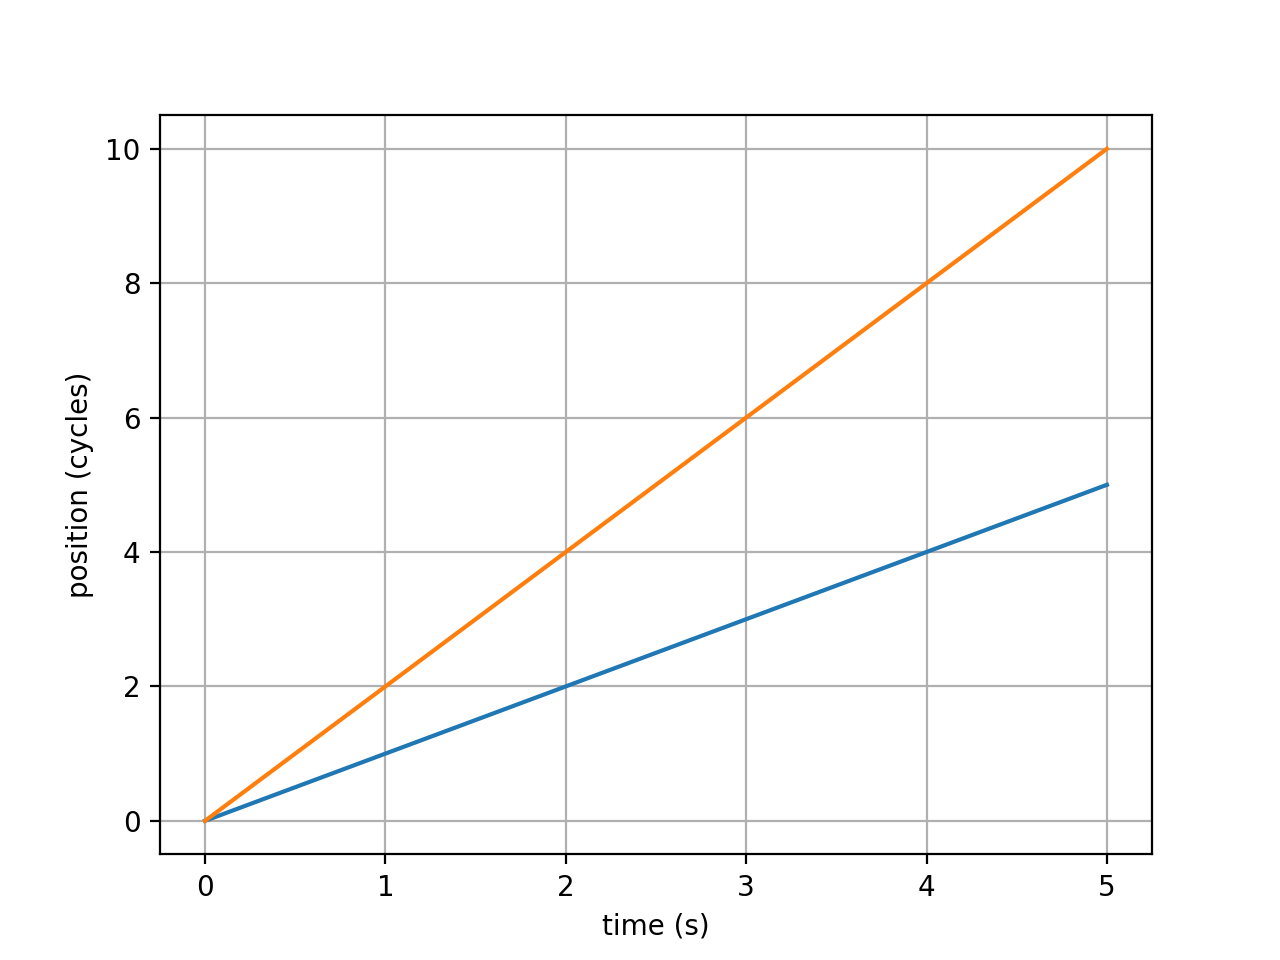

In [25]:
plt.figure()
plt.plot(ts, ref_encoder1, ts, ref_encoder2)
plt.ylabel('position (cycles)')
plt.xlabel('time (s)')
plt.grid()

In [27]:
i = 0

K = float(Ks[i])
print('K = Ks[{}] = {:5.3f}'.format(i,K))

K = Ks[0] = 25.000


In [28]:
# Add position reference signal
mip.add_signals('ref_encoder1',
                'ref_encoder2')

# add filters to interpolate data
mip.add_filter('ref_encoder1',
                Interp(fp = ts, xp = ref_encoder1, period = T),
                ['clock'],
                ['ref_encoder1'])

mip.add_filter('ref_encoder2',
                Interp(fp = ts, xp = ref_encoder2, period = T),
                ['clock'],
                ['ref_encoder2'])

# add differentiators
mip.add_signals('velocity1','velocity2')
mip.add_filter('velocity1', Differentiator(), ['clock', 'encoder1'],['velocity1'])
mip.add_filter('velocity2', Differentiator(), ['clock', 'encoder2'],['velocity2'])

# Open-loop controllers
mip.add_filter('Controller1',
                Feedback(block = Gain(gain = K)),
                ['encoder1','ref_encoder1'],
                ['pwm1'])

mip.add_filter('Controller2',
                Feedback(block = Gain(gain = K)),
                ['encoder2','ref_encoder2'],
                ['pwm2'])

# add logger
mip.add_sink('logger', Logger(auto_reset = True),
             ['clock', 
              'encoder1', 'encoder2', 
              'velocity1','velocity2',
              'ref_encoder1','ref_encoder2',
              'pwm1','pwm2'])

# add a timer to stop the controller
mip.add_timer('stop',
               Constant(value = 0),
               None, ['is_running'],
               period = 5, repeat = False)

print(mip.info('all'))

<class 'pyctrl.rc.drive.Controller'> with:
  1 timer(s), 16 signal(s),
  4 source(s), 6 filter(s), and 3 sink(s)
> timers
  1. stop[Constant, period = 5.0, enabled] >> is_running
> signals
  1. clock
  2. duty
  3. encoder1
  4. encoder2
  5. is_running
  6. pitch
  7. pwm1
  8. pwm2
  9. ref_encoder1
  10. ref_encoder2
  11. ref_velocity1
  12. ref_velocity2
  13. roll
  14. velocity1
  15. velocity2
  16. yaw
> sources
  1. clock[MPU9250, enabled] >> clock
  2. orientation[TaitBryanAngles, enabled] >> pitch, roll, yaw
  3. encoder1[Encoder, enabled] >> encoder1
  4. encoder2[Encoder, enabled] >> encoder2
> filters
  1. clock >> ref_encoder1[Interp, enabled] >> ref_encoder1
  2. clock >> ref_encoder2[Interp, enabled] >> ref_encoder2
  3. clock, encoder1 >> velocity1[Differentiator, enabled] >> velocity1
  4. clock, encoder2 >> velocity2[Differentiator, enabled] >> velocity2
  5. encoder1, ref_encoder1 >> Controller1[Feedback, enabled] >> pwm1
  6. encoder2, ref_encoder2 >> Controller2

Run the device and collect the output data:

In [29]:
mip.set_source('encoder1', reset=True)
mip.set_source('encoder2', reset=True)
mip.set_source('clock', reset=True)
mip.set_filter('ref_encoder1', reset=True)
mip.set_filter('ref_encoder2', reset=True)
with mip:
    mip.join()
log = mip.get_sink('logger', 'log')

Calculate average velocity and standard deviation after 1 second:

In [30]:
clock = log['clock']
mean_velocity1 = log['velocity1'][clock > clock[0] + 1].mean()
std_velocity1 = log['velocity1'][clock > clock[0] + 1].std()
error_velocity1 = np.fabs(log['velocity1'][clock > clock[0] + 1]-ref_velocity1).mean()
print('velocity1: mean = {:5.3f}, std = {:5.3f}%, error = {:5.3f}%'.format(mean_velocity1,100*std_velocity1/mean_velocity1, 100*error_velocity1/ref_velocity1))

mean_velocity2 = log['velocity2'][clock > clock[0] + 1].mean()
std_velocity2 = log['velocity2'][clock > clock[0] + 1].std()
error_velocity2 = np.fabs(log['velocity2'][clock > clock[0] + 1]-ref_velocity2).mean()
print('velocity2: mean = {:5.3f}, std = {:5.3f}%, error = {:5.3f}%'.format(mean_velocity2,100*std_velocity2/mean_velocity2, 100*error_velocity2/ref_velocity2))

velocity1: mean = 0.971, std = 11.933%, error = 6.312%
velocity2: mean = 1.993, std = 7.574%, error = 4.822%


Plot *velocities versus time*:

<IPython.core.display.Javascript object>


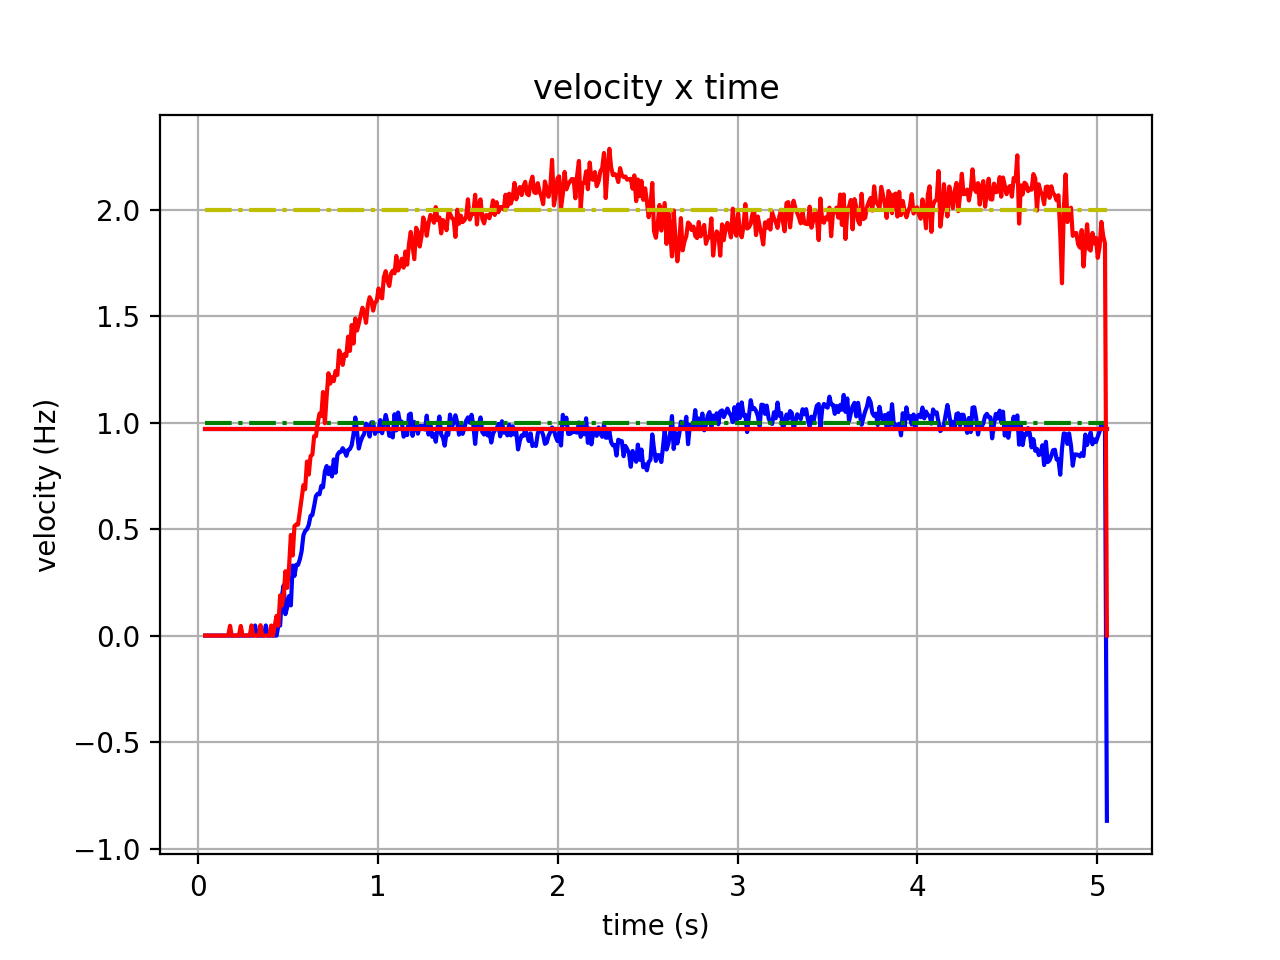

In [31]:
plt.figure()
plt.plot(clock, log['velocity1'], 'b',
         [clock[0],clock[-1]], [mean_velocity1,mean_velocity1], 'b',
         [clock[0],clock[-1]], [ref_velocity1,ref_velocity1], 'g-.',
         log['clock'], log['velocity2'], 'r',
         [clock[0],clock[-1]], [mean_velocity1,mean_velocity1], 'r',
         [clock[0],clock[-1]], [ref_velocity2,ref_velocity2], 'y-.')
plt.xlabel('time (s)')
plt.ylabel('velocity (Hz)')
plt.title('velocity x time')
plt.grid()

<IPython.core.display.Javascript object>


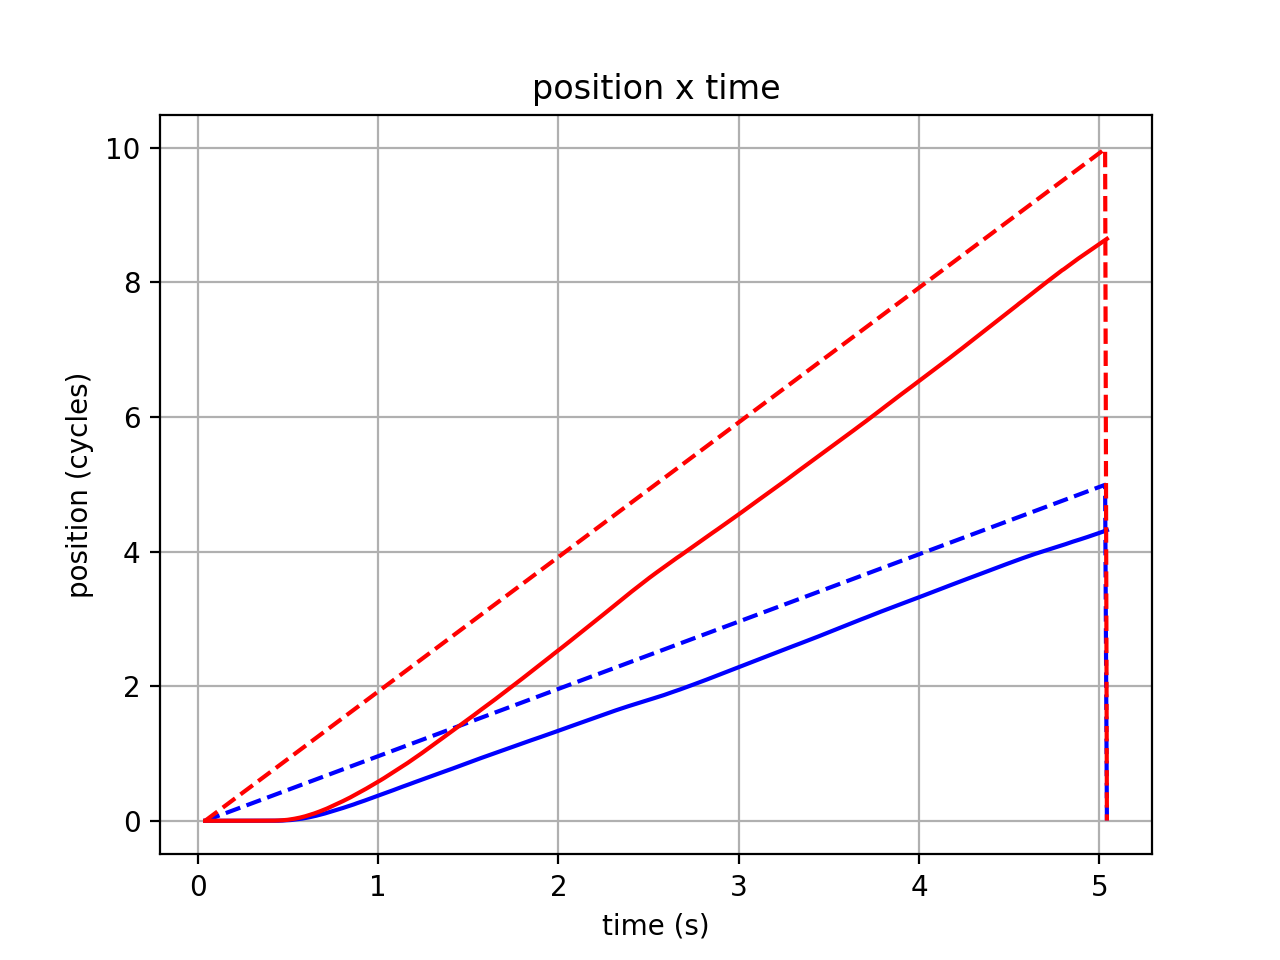

In [32]:
plt.figure()
plt.plot(clock[0:-1], log['encoder1'][0:-1], 'b',
         clock[0:-1], log['ref_encoder1'][0:-1], 'b--',
         clock[0:-1], log['encoder2'][0:-1], 'r',
         clock[0:-1], log['ref_encoder2'][0:-1], 'r--')
plt.xlabel('time (s)')
plt.ylabel('position (cycles)')
plt.title('position x time')
plt.grid()

Plot *pwm versus time*:

<IPython.core.display.Javascript object>


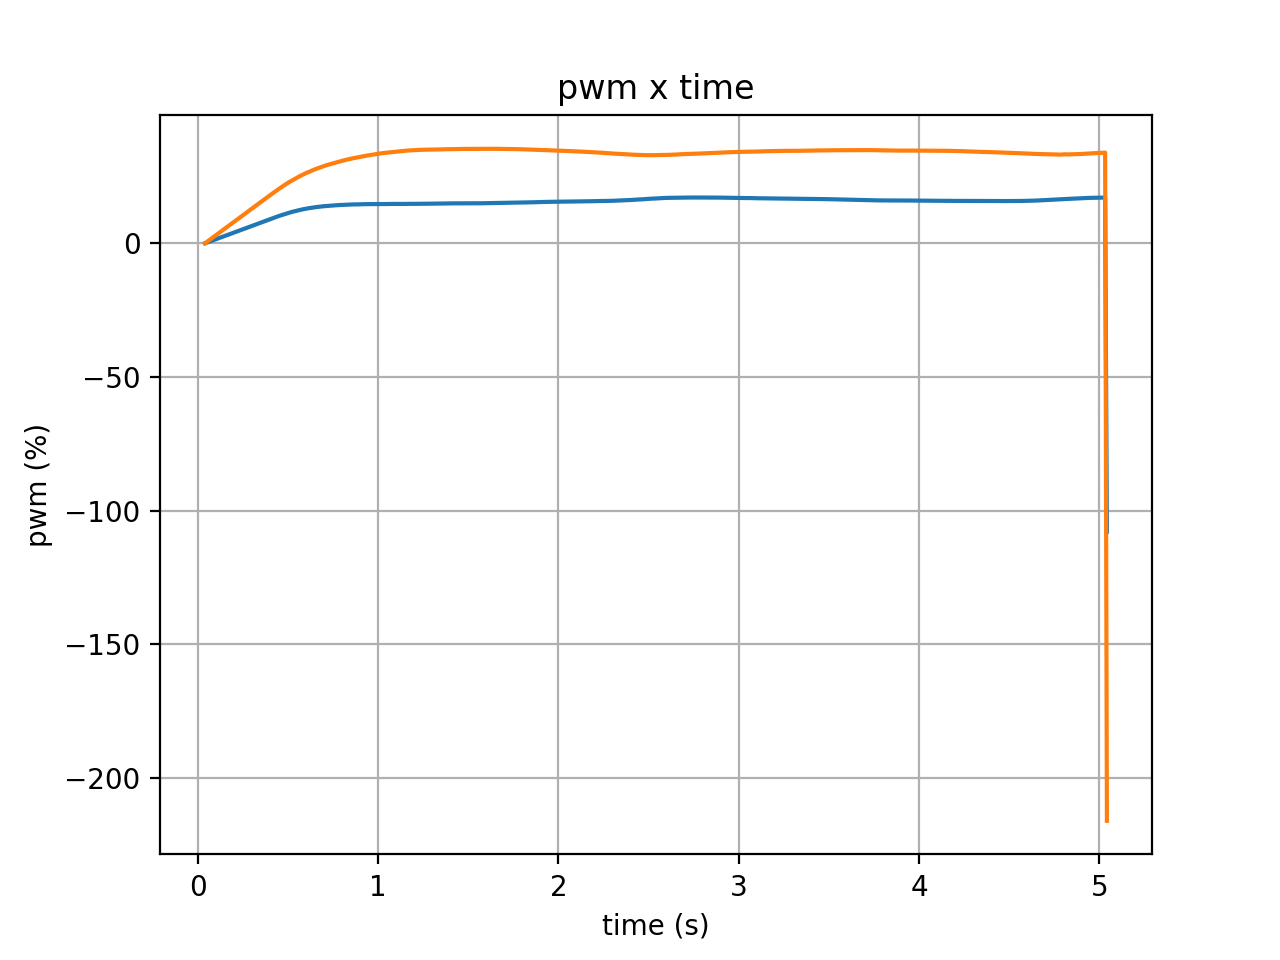

In [33]:
plt.figure()
plt.plot(clock[0:-1], log['pwm1'][0:-1],
         clock[0:-1], log['pwm2'][0:-1])
plt.ylabel('pwm (%)')
plt.xlabel('time (s)')
plt.title('pwm x time')
plt.grid()

## Integral velocity control

The above controller can be rearranged in the form of an integral controller:

<img src="http://guitar.ucsd.edu/cosmos7/images/blk5.svg" width="600">

in which the reference is given as a velocity.


### Tasks
1. Implement an integral feedback controller for position control using $k = 25$, set the position reference for the motor1 to be 1 cycle and the position reference for the motor2 to be 2 cycles and run your controller for 5 seconds.
2. Import the data and plot time vs position and time vs reference.
3. What happens as $k$ is gets large?

In [ ]:
i = 0

Kp = 0
Ki = float(Ks[i])
print('K = Ks[{}] = {:5.3f}'.format(i,K))

Add the reference input and the closed-loop controller to the device:

In [ ]:
T = 30
Ts = 0.01

# Add reference signal
mip.add_signals('ref_velocity1',
                'ref_velocity2')

# add differentiators
mip.add_signals('velocity1','velocity2')
mip.add_filter('velocity1', Differentiator(), ['clock', 'encoder1'],['velocity1'])
mip.add_filter('velocity2', Differentiator(), ['clock', 'encoder2'],['velocity2'])

# Open-loop controllers
mip.add_filter('Controller1',
                Feedback(block = System(model = PID(Kp = Kp, Ki = Ki, period = Ts))),
                ['velocity1','ref_velocity1'],
                ['pwm1'])

mip.add_filter('Controller2',
                Feedback(block = System(model = PID(Kp = Kp, Ki = Ki, period = Ts))),
                ['velocity2','ref_velocity2'],
                ['pwm2'])

# add logger
mip.add_sink('logger', Logger(auto_reset = True),
             ['clock', 
              'encoder1', 'encoder2', 
              'velocity1','velocity2',
              'pwm1','pwm2'])

# add a timer to stop the controller
mip.add_timer('stop',
               Constant(value = 0),
               None, ['is_running'],
               period = T, repeat = False)

print(mip.info('all'))

Run the device and collect the output data:

In [ ]:
ref_velocity1 = 6
ref_velocity2 = 8

mip.set_signal('ref_velocity1', ref_velocity1)
mip.set_signal('ref_velocity2', ref_velocity2)
with mip:
    mip.join()
log = mip.get_sink('logger', 'log')

Calculate average velocity and standard deviation after 1 second:

In [ ]:
clock = log['clock']
mean_velocity1 = log['velocity1'][clock > clock[0] + 1].mean()
std_velocity1 = log['velocity1'][clock > clock[0] + 1].std()
error_velocity1 = np.fabs(log['velocity1'][clock > clock[0] + 1]-ref_velocity1).mean()
print('velocity1: mean = {:5.3f}, std = {:5.3f}%, error = {:5.3f}%'.format(mean_velocity1,100*std_velocity1/mean_velocity1, 100*error_velocity1/ref_velocity1))

mean_velocity2 = log['velocity2'][clock > clock[0] + 1].mean()
std_velocity2 = log['velocity2'][clock > clock[0] + 1].std()
error_velocity2 = np.fabs(log['velocity2'][clock > clock[0] + 1]-ref_velocity2).mean()
print('velocity2: mean = {:5.3f}, std = {:5.3f}%, error = {:5.3f}%'.format(mean_velocity2,100*std_velocity2/mean_velocity2, 100*error_velocity2/ref_velocity2))

Plot *velocities versus time*:

In [ ]:
plt.figure()
plt.plot(log['clock'], log['velocity1'], 'b',
         [clock[0],clock[-1]], [ref_velocity1,ref_velocity1], 'b--',
         [clock[0],clock[-1]], [mean_velocity1,mean_velocity1], 'b',
         log['clock'], log['velocity2'], 'r',
         [clock[0],clock[-1]], [ref_velocity2,ref_velocity2], 'r--',
         [clock[0],clock[-1]], [mean_velocity2,mean_velocity2], 'r' )
plt.xlabel('time (s)')
plt.ylabel('velocity (Hz)')
plt.title('velocity x time')
plt.grid()

Plot *pwm versus time*:

In [ ]:
plt.figure()
plt.plot(clock, log['pwm1'],
         clock, log['pwm2'])
plt.ylabel('pwm (%)')
plt.xlabel('time (s)')
plt.title('pwm x time')
plt.grid()

##  Steering control

As you studied before, the relation between the `pwm` inputs, the forward velocity, $v$, and the angular velocity, $\omega$, can be represented by the relations:

$$
\begin{aligned}
  \omega &= \frac{r}{\ell} (\omega_r - \omega_l), \\
  v &= \frac{r}{2} (\omega_r + \omega_l)
\end{aligned}
$$

where $r$ is the radius of the wheels and $\ell$ is the distance between the wheels. The above relationships can be represented by the block diagram:

<img src="http://guitar.ucsd.edu/cosmos7/images/blk6.svg" width="250">

Because the angular velocity, $\omega$, is the derivative of the heading angle, $\theta$, steering control can be performed based on the following diagram:

<img src="http://guitar.ucsd.edu/cosmos7/images/blk7.svg" width="600">

where $\bar{\theta}$ is the reference angle and $\overline{\mathrm{pwm}}$ is a open-loop control input for the forward velocity. Of course one could also close the loop on the forward velocity as well.

The signal corresponding to the heading angle $\theta$ in the MIP is the signal `yaw`.

### Tasks

1. Implement the above steering feedback controller using $k = 10$, set the yaw reference to be 0.5 rad and the pwm reference to be 30% and run your controller for 5 seconds.
2. Import the data, calculate the average and standard deviation of the yaw.
3. Plot time vs yaw and time vs the pwm signals.
4. Vary the value of the gain $k$.

### Questions

1. What happens as $k$ gets large?

In [34]:
mip.reset()

In [35]:
T = 5
K = 10

In [36]:
# Add reference signal
mip.add_signals('ref_yaw')

# add differentiators
mip.add_signals('velocity1','velocity2')
mip.add_filter('velocity1', Differentiator(), ['clock', 'encoder1'],['velocity1'])
mip.add_filter('velocity2', Differentiator(), ['clock', 'encoder2'],['velocity2'])

# Closed-loop controllers
mip.add_filter('Controller1',
                Feedback(block = Gain(gain = K)),
                ['yaw','ref_yaw'],
                ['pwm_yaw'])

mip.add_filter('Sum1',
                Subtract(),
                ['pwm_yaw','ref_pwm1'],
                ['pwm1'])

mip.add_filter('Sum2',
                Sum(),
                ['pwm_yaw','ref_pwm2'],
                ['pwm2'])

# add logger
mip.add_sink('logger', Logger(auto_reset = True),
             ['clock', 
              'encoder1', 'encoder2', 
              'velocity1','velocity2',
              'pwm1','pwm2',
              'yaw'])

# add a timer to stop the controller
mip.add_timer('stop',
               Constant(value = 0),
               None, ['is_running'],
               period = T, repeat = False)

print(mip.info('all'))

<class 'pyctrl.rc.drive.Controller'> with:
  1 timer(s), 16 signal(s),
  4 source(s), 5 filter(s), and 3 sink(s)
> timers
  1. stop[Constant, period = 5.0, enabled] >> is_running
> signals
  1. clock
  2. duty
  3. encoder1
  4. encoder2
  5. is_running
  6. pitch
  7. pwm1
  8. pwm2
  9. pwm_yaw
  10. ref_pwm1
  11. ref_pwm2
  12. ref_yaw
  13. roll
  14. velocity1
  15. velocity2
  16. yaw
> sources
  1. clock[MPU9250, enabled] >> clock
  2. orientation[TaitBryanAngles, enabled] >> pitch, roll, yaw
  3. encoder1[Encoder, enabled] >> encoder1
  4. encoder2[Encoder, enabled] >> encoder2
> filters
  1. clock, encoder1 >> velocity1[Differentiator, enabled] >> velocity1
  2. clock, encoder2 >> velocity2[Differentiator, enabled] >> velocity2
  3. yaw, ref_yaw >> Controller1[Feedback, enabled] >> pwm_yaw
  4. pwm_yaw, ref_pwm1 >> Sum1[Subtract, enabled] >> pwm1
  5. pwm_yaw, ref_pwm2 >> Sum2[Sum, enabled] >> pwm2
> sinks
  1. pwm1 >> motor1[Motor, disabled]
  2. pwm2 >> motor2[Motor, disabl

In [37]:
ref_pwm1 = 30
ref_pwm2 = 30
ref_yaw = 0.5

mip.set_signal('ref_pwm1', ref_pwm1)
mip.set_signal('ref_pwm2', ref_pwm2)
mip.set_signal('ref_yaw', ref_yaw)
with mip:
    mip.join()
log = mip.get_sink('logger', 'log')

Calculate the average heading angle and its standard deviation:

In [38]:
clock = log['clock']
mean_yaw = log['yaw'][clock > clock[0] + 1].mean()
std_yaw = log['yaw'][clock > clock[0] + 1].std()
print('yaw: mean = {:5.3f}, std = {:5.3f}%'.format(mean_yaw,100*std_yaw/mean_yaw))

yaw: mean = 1.381, std = 69.269%


Plot the heading angle:

<IPython.core.display.Javascript object>


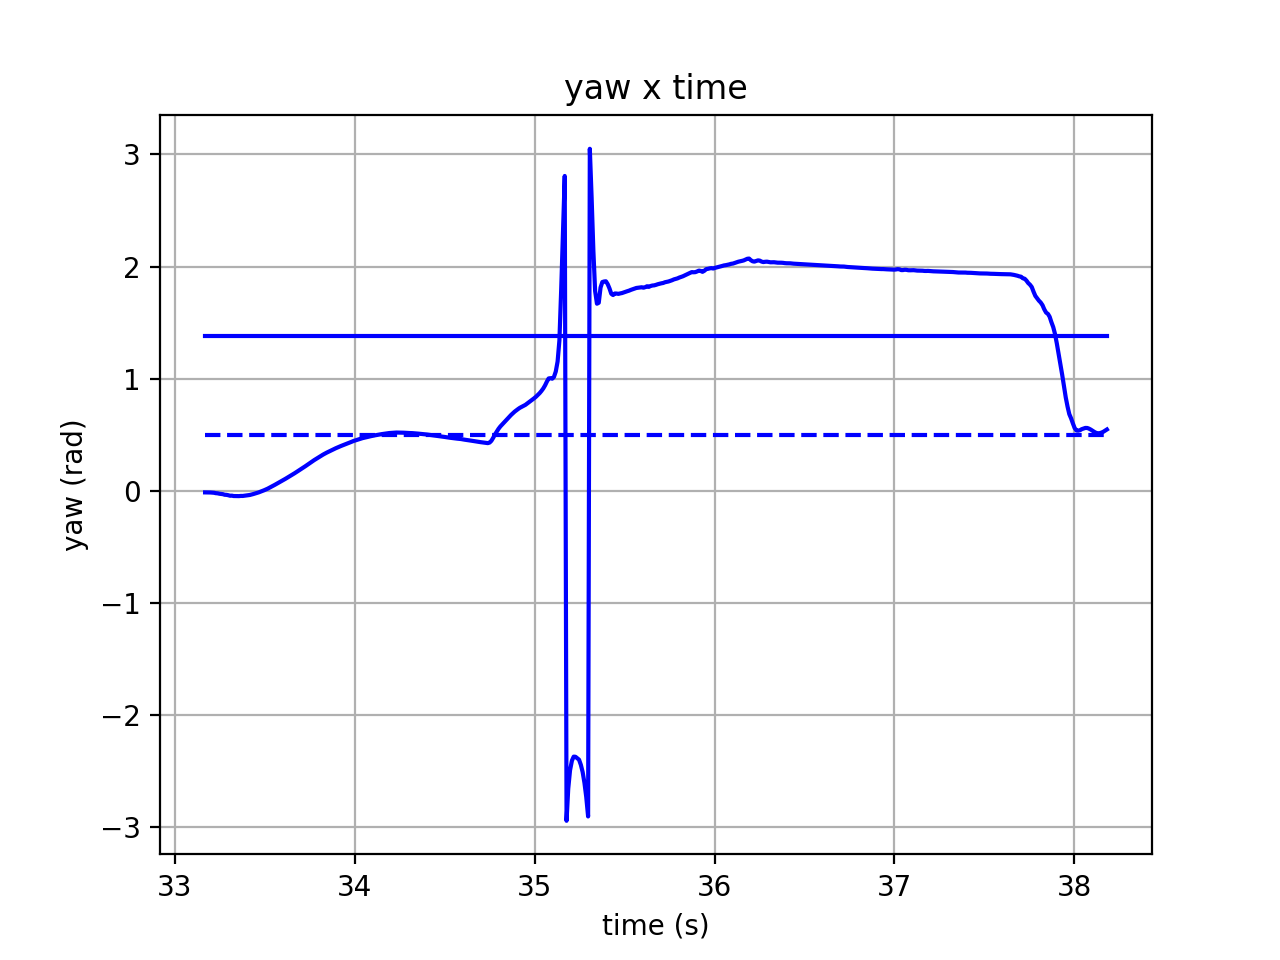

In [39]:
plt.figure()
plt.plot(log['clock'], log['yaw'], 'b',
         [clock[0],clock[-1]], [ref_yaw,ref_yaw], 'b--',
         [clock[0],clock[-1]], [mean_yaw,mean_yaw], 'b')
plt.xlabel('time (s)')
plt.ylabel('yaw (rad)')
plt.title('yaw x time')
plt.grid()

Plot *pwm versus time*:

<IPython.core.display.Javascript object>


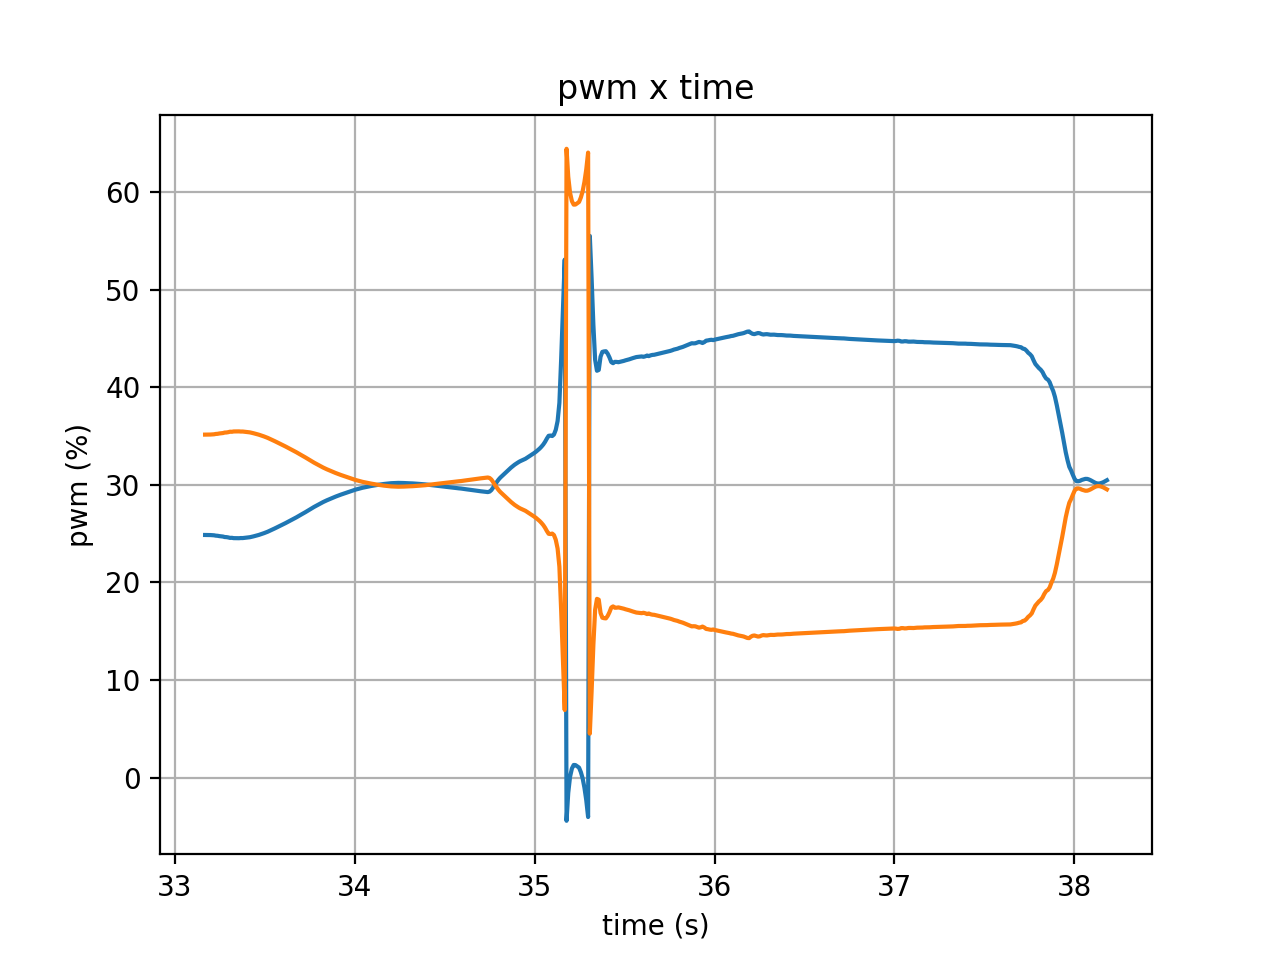

In [40]:
plt.figure()
plt.plot(clock, log['pwm1'],
         clock, log['pwm2'])
plt.ylabel('pwm (%)')
plt.xlabel('time (s)')
plt.title('pwm x time')
plt.grid()

Plot *velocities versus time*:

<IPython.core.display.Javascript object>


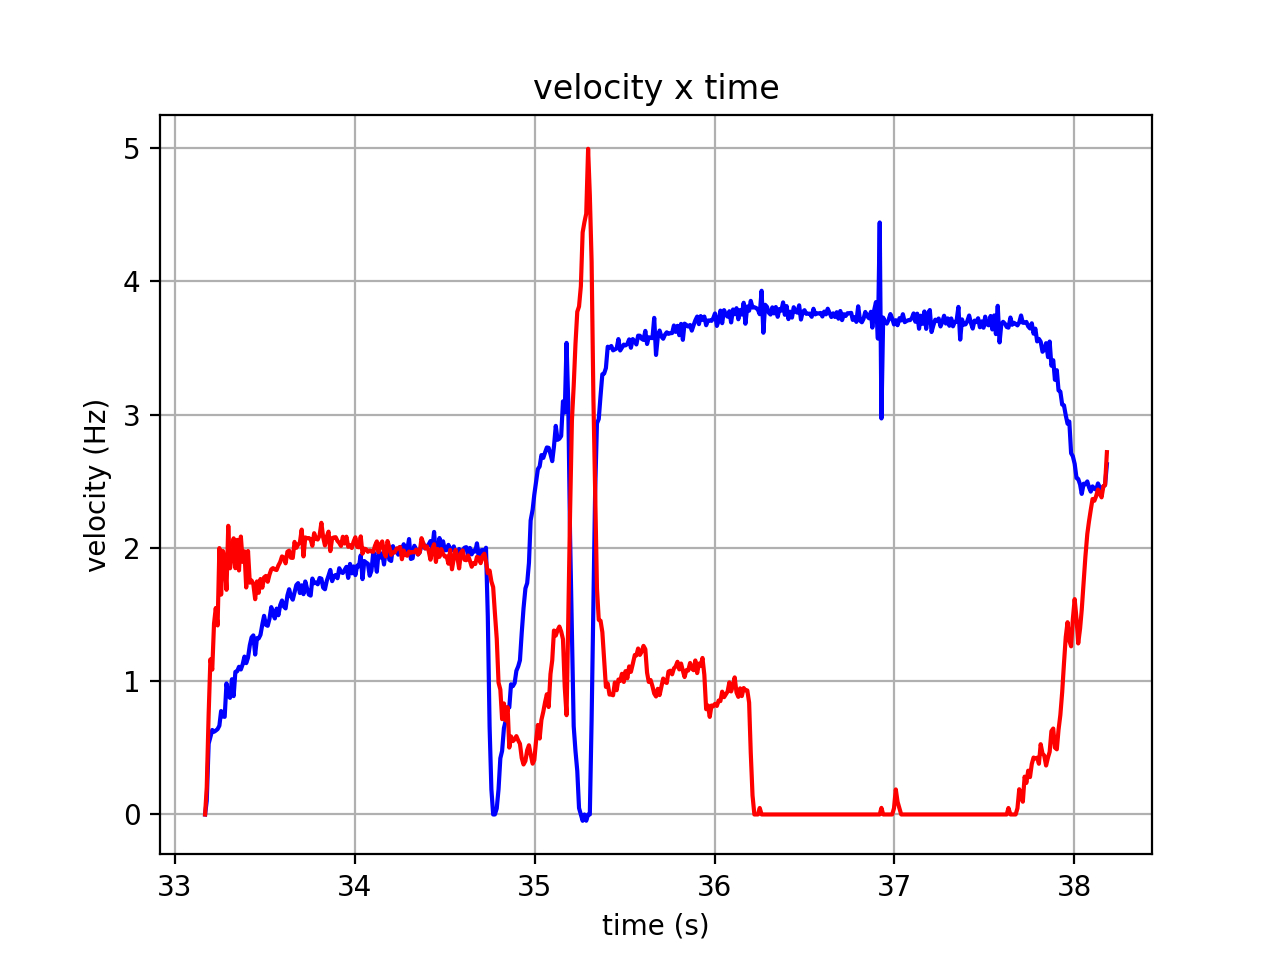

In [41]:
plt.figure()
plt.plot(log['clock'], log['velocity1'], 'b',
         log['clock'], log['velocity2'], 'r')
plt.xlabel('time (s)')
plt.ylabel('velocity (Hz)')
plt.title('velocity x time')
plt.grid()

### Tasks

1. Try predicting the movement of the MIP for each of the following reference signals.
2. Run the controller using these signals as input.

### Questions

1. How did the MIP moved in each case?

#### Reference signal #1

In [42]:
# Interpolated input signals
T = 5
ts   = [0, T]
yaws = 2*np.pi*np.array([0, 2])

<IPython.core.display.Javascript object>


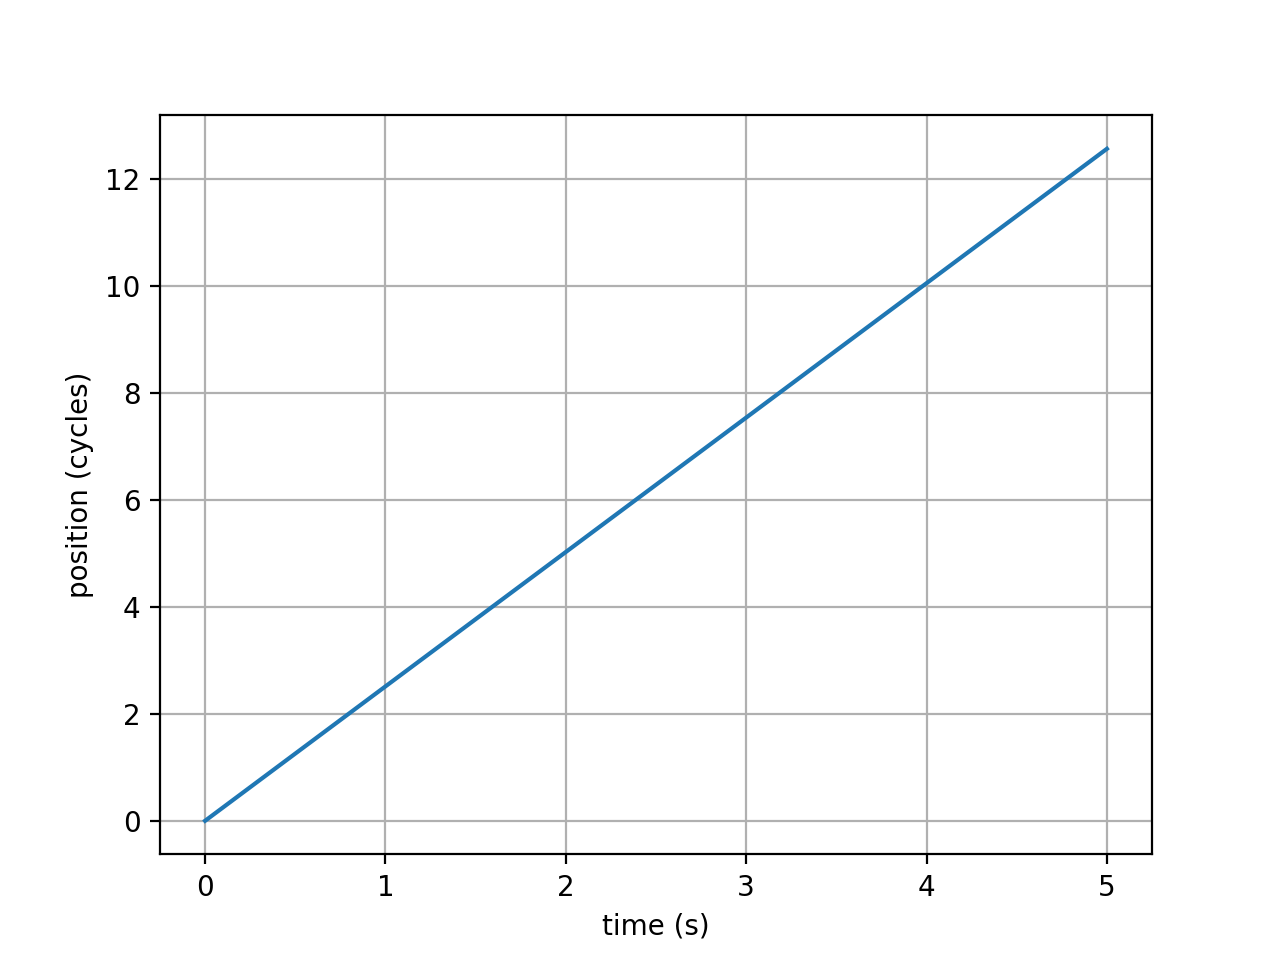

In [43]:
plt.figure()
plt.plot(ts, yaws)
plt.ylabel('position (cycles)')
plt.xlabel('time (s)')
plt.grid()

#### Reference signal #2

In [46]:
# Interpolated input signals
T = 10
ts   = [0, T/4, T/2, 3*T/4, T]
yaws = 2*np.pi*np.array([0, 1, 0, 1, 0])

<IPython.core.display.Javascript object>


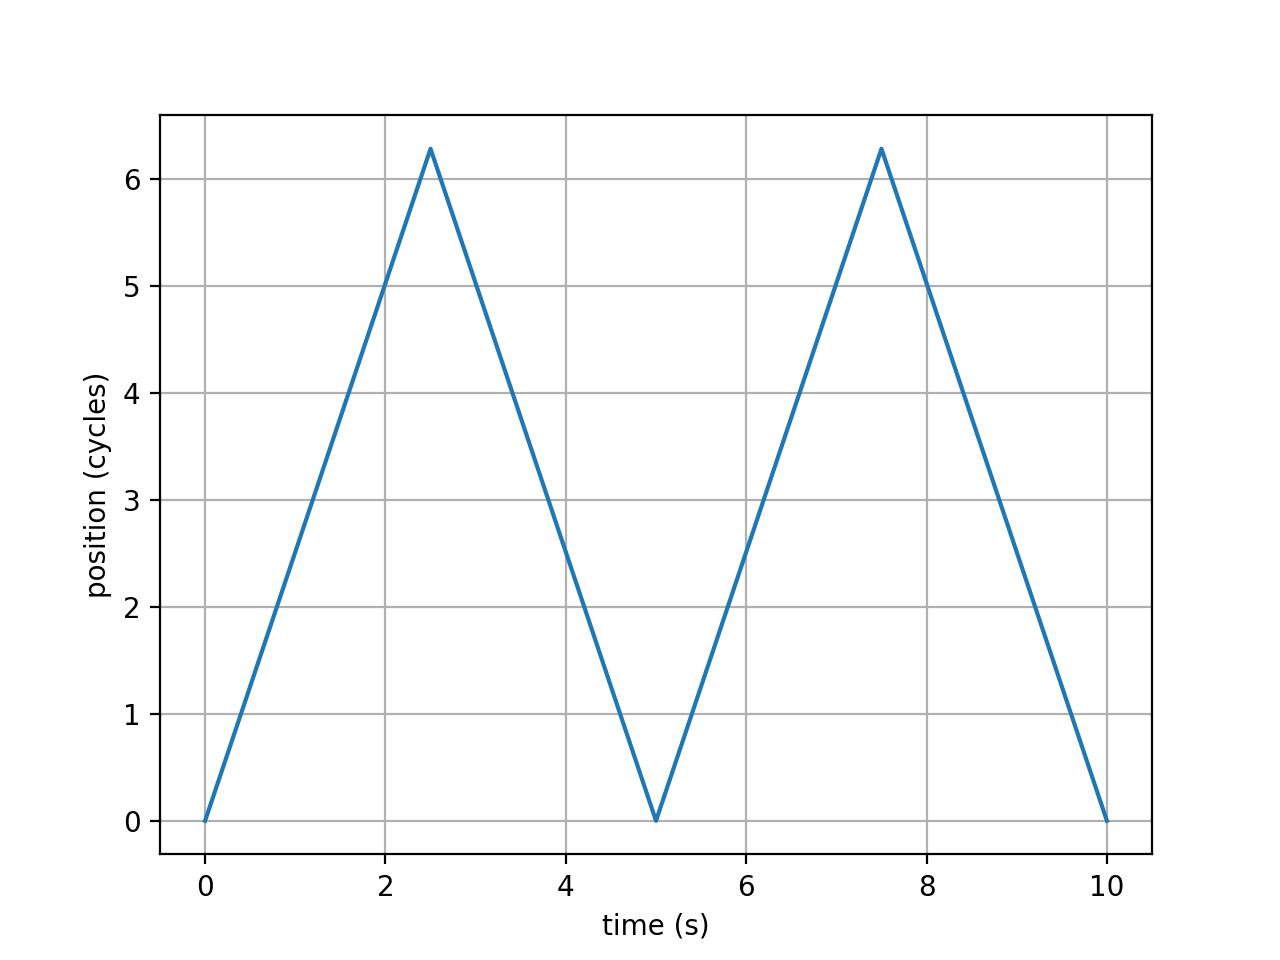

In [47]:
plt.figure()
plt.plot(ts, yaws)
plt.ylabel('position (cycles)')
plt.xlabel('time (s)')
plt.grid()

#### Reference signal #3

In [50]:
# Interpolated input signals
T = 10
ts   = [0, T/4, T/4, 2*T/4, 2*T/4, 3*T/4, 3*T/4,   T, T]
yaws = 2*np.pi*np.array([0,   0, 1/4,   1/4,   1/2,   1/2,   3/4, 3/4, 1])

<IPython.core.display.Javascript object>


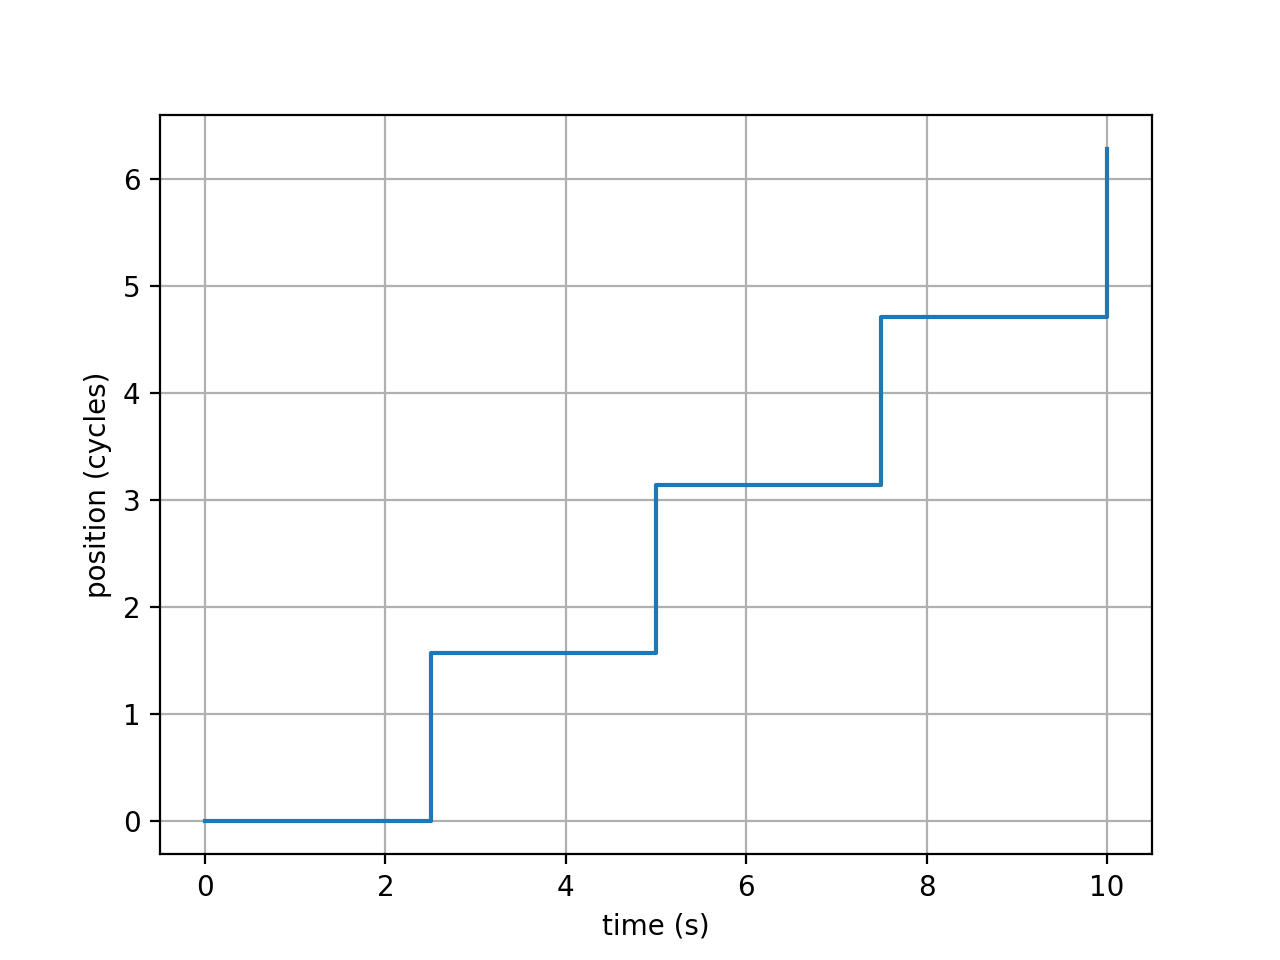

In [51]:
plt.figure()
plt.plot(ts, yaws)
plt.ylabel('position (cycles)')
plt.xlabel('time (s)')
plt.grid()

Run the controller:

In [66]:
K=100

In [67]:
# Add reference signal
mip.add_signals('ref_yaw')

# add filters to interpolate data
mip.add_filter('ref_yaw',
                Interp(fp = ts, xp = yaws, period = T),
                ['clock'],
                ['ref_yaw'])

# add differentiators
mip.add_signals('velocity1','velocity2')
mip.add_filter('velocity1', Differentiator(), ['clock', 'encoder1'],['velocity1'])
mip.add_filter('velocity2', Differentiator(), ['clock', 'encoder2'],['velocity2'])

# Closed-loop controllers
mip.add_filter('wrap', Wrap(), ['yaw'], ['continuous_yaw'])

mip.add_filter('Controller1',
                Feedback(block = Gain(gain = K)),
                ['continuous_yaw','ref_yaw'],
                ['pwm_yaw'])

mip.add_filter('Sum1',
                Subtract(),
                ['pwm_yaw','ref_pwm1'],
                ['pwm1'])

mip.add_filter('Sum2',
                Sum(),
                ['pwm_yaw','ref_pwm2'],
                ['pwm2'])

# add logger
mip.add_sink('logger', Logger(auto_reset = True),
             ['clock', 
              'encoder1', 'encoder2', 
              'velocity1','velocity2',
              'pwm1','pwm2',
              'continuous_yaw', 'ref_yaw'])

# add a timer to stop the controller
mip.add_timer('stop',
               Constant(value = 0),
               None, ['is_running'],
               period = T, repeat = False)

print(mip.info('all'))

<class 'pyctrl.rc.drive.Controller'> with:
  1 timer(s), 17 signal(s),
  4 source(s), 7 filter(s), and 3 sink(s)
> timers
  1. stop[Constant, period = 10.0, enabled] >> is_running
> signals
  1. clock
  2. continuous_yaw
  3. duty
  4. encoder1
  5. encoder2
  6. is_running
  7. pitch
  8. pwm1
  9. pwm2
  10. pwm_yaw
  11. ref_pwm1
  12. ref_pwm2
  13. ref_yaw
  14. roll
  15. velocity1
  16. velocity2
  17. yaw
> sources
  1. clock[MPU9250, enabled] >> clock
  2. orientation[TaitBryanAngles, enabled] >> pitch, roll, yaw
  3. encoder1[Encoder, enabled] >> encoder1
  4. encoder2[Encoder, enabled] >> encoder2
> filters
  1. clock >> ref_yaw[Interp, enabled] >> ref_yaw
  2. clock, encoder1 >> velocity1[Differentiator, enabled] >> velocity1
  3. clock, encoder2 >> velocity2[Differentiator, enabled] >> velocity2
  4. yaw >> wrap[Wrap, enabled] >> continuous_yaw
  5. continuous_yaw, ref_yaw >> Controller1[Feedback, enabled] >> pwm_yaw
  6. pwm_yaw, ref_pwm1 >> Sum1[Subtract, enabled] >> pwm

In [68]:
ref_pwm1 = 30
ref_pwm2 = 30

mip.set_signal('ref_pwm1', ref_pwm1)
mip.set_signal('ref_pwm2', ref_pwm2)
mip.set_source('clock', reset=True)
mip.set_filter('wrap', reset=True)
mip.set_filter('ref_yaw', reset=True)
with mip:
    mip.join()
log = mip.get_sink('logger', 'log')

Plot the heading angle:

<IPython.core.display.Javascript object>


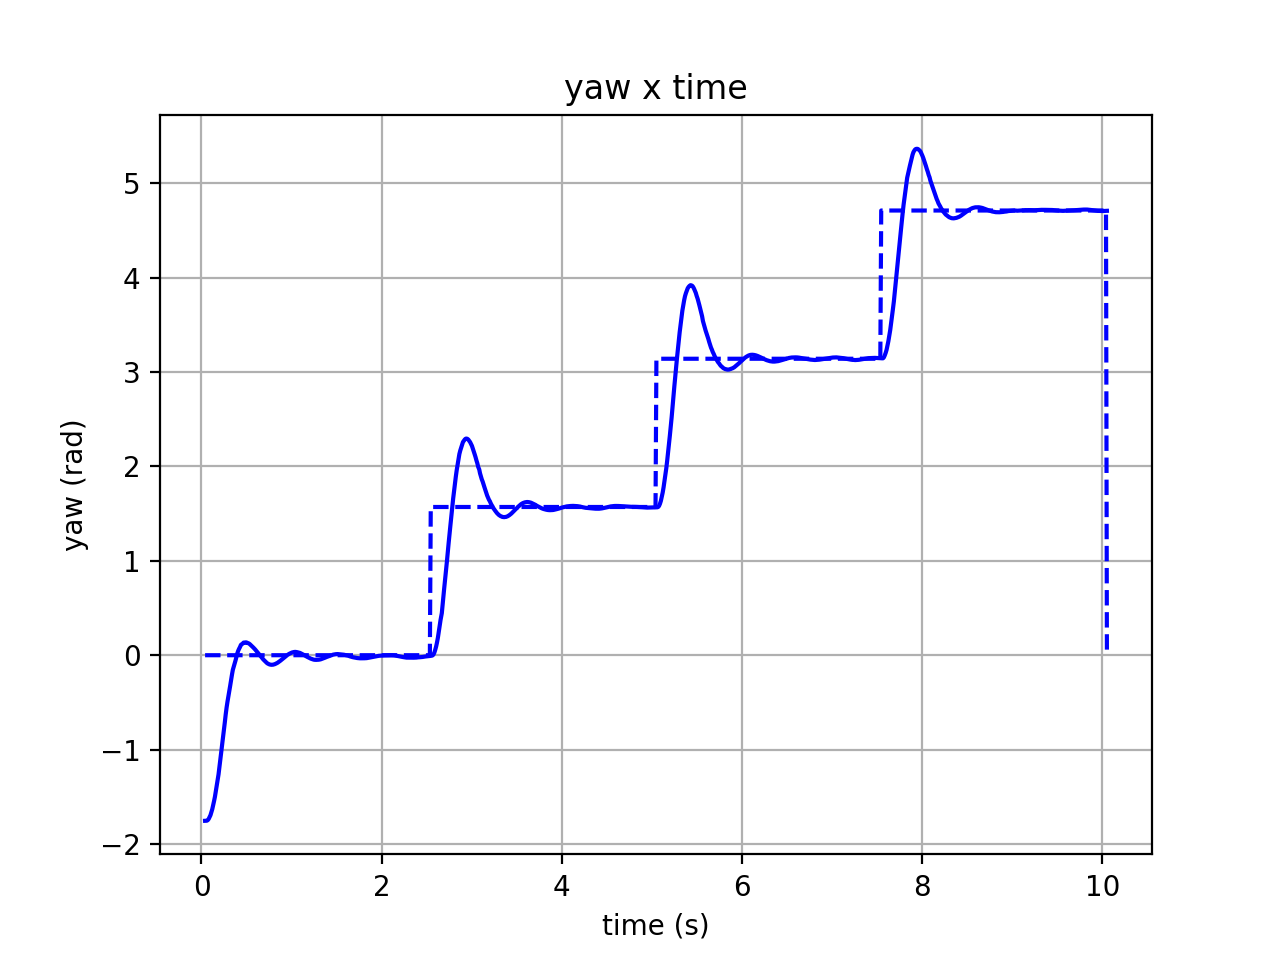

In [69]:
plt.figure()
plt.plot(log['clock'], log['continuous_yaw'], 'b',
         log['clock'], log['ref_yaw'], 'b--')
plt.xlabel('time (s)')
plt.ylabel('yaw (rad)')
plt.title('yaw x time')
plt.grid()

Plot *pwm versus time*:

<IPython.core.display.Javascript object>


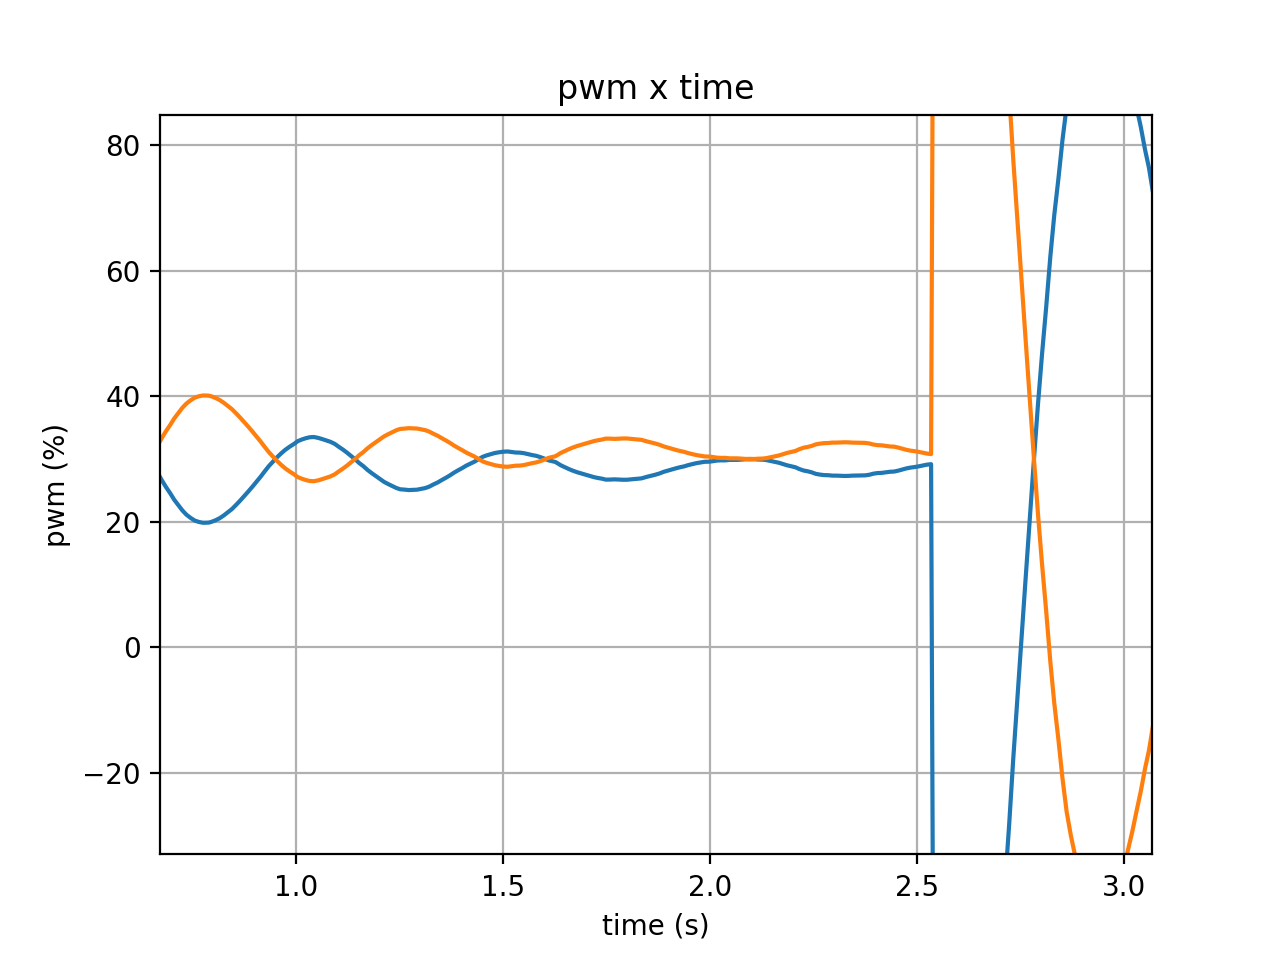

In [70]:
plt.figure()
plt.plot(log['clock'], log['pwm1'],
         log['clock'], log['pwm2'])
plt.ylabel('pwm (%)')
plt.xlabel('time (s)')
plt.title('pwm x time')
plt.grid()

Plot *velocities versus time*:

In [ ]:
plt.figure()
plt.plot(log['clock'], log['velocity1'], 'b',
         log['clock'], log['velocity2'], 'r')
plt.xlabel('time (s)')
plt.ylabel('velocity (Hz)')
plt.title('velocity x time')
plt.grid()